In [1]:
%matplotlib inline

from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.image.zds import ZDS
from fish.util.fileio import read_image
from skimage.transform import resize, downscale_local_mean
from skimage.exposure import rescale_intensity as rescale
from skimage.io import imsave, imread
from scipy.io import loadmat
from fish.util.plot import proj_fuse
from scipy.ndimage.filters import gaussian_filter1d, median_filter
from functools import partial
import dask.array as da
import dask

from glob import glob
from h5py import File

import matplotlib.gridspec as gridspec
from scipy.stats import zscore
from scipy.signal import decimate
import matplotlib.pyplot as plt
plt.style.use('npg')

import sys
import json
import pathlib as pl
from os.path import sep

import numpy as np

In [3]:
def offset_colorbar(fig, axis, **kwargs):
    from matplotlib.pyplot import colorbar
    pos = axis.get_position()
    b = colorbar(axis.get_images()[0], cax=fig.add_axes([pos.x0 + pos.width, pos.y0, .01, pos.height/2]), **kwargs)
    b.outline.set_linewidth(0)
    return b    

def my_proj(data, fun, aspect):
    from skimage.transform import resize
    from numpy import zeros, array
    # project over z and y
    old_dims = array(data.shape)
    new_dims = array(aspect) * old_dims
    proj_axes = [0,1]    
    projs = []
    for axis, dim in enumerate(new_dims[:2]):
        indexer = list(range(len(new_dims)))
        indexer.pop(axis)
        projs.append(resize(fun(data, axis), new_dims[indexer], mode='constant', preserve_range=True))
    
    output = zeros([new_dims[0] + new_dims[1], new_dims[2]])
    output[:new_dims[0]] = projs[1]
    output[new_dims[0]:] = projs[0]
    
    return output
    

def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())

    
def trigger_data(triggers, window, fnames, average=False, parallelism=None):
    from fish.util.fileio import read_image    
    from numpy import array, zeros
    
    sample = read_image(fnames[0])

    if average:
        dims = list(sample.shape)
        dims.insert(0, len(window))
        ims_trial = zeros(dims)
    else: 
        dims = list(sample.shape)
        dims.insert(0, len(window))
        dims.insert(0, len(triggers))
        ims_trial = zeros(dims)
    
    for ind, trig in enumerate(triggers):        
        tr = read_image(array(fnames)[trig + window],roi=None, parallelism=parallelism)
        
        if average:
            ims_trial += tr.astype('float32')/len(triggers)

        else:
            ims_trial[ind] = tr
    
    return ims_trial

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

def standard_clim(axes, clim_scaling=(1,1)):
    clim = np.array([ax.get_images()[0].get_clim() for ax in axes])
    clim = (clim.min() * clim_scaling[0], clim.max() * clim_scaling[1])
    [ax.get_images()[0].set_clim(clim) for ax in axes]

In [4]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/']

In [5]:
dirs = {}
dirs['base_raw'] = potential_paths[0]
exp_name = dirs['base_raw'].split(sep)[-2]
dirs['ephys'] = dirs['base_raw'] + 'ephys/'
dirs['raw'] = dirs['base_raw'] + 'raw/'
exp = ZDS(dirs['raw'])
dirs['base_output'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp.metadata['data_header'] + sep
dirs['output'] = '/groups/ahrens/ahrenslab/davis/data/ngm/'
dirs['dff'] = dirs['base_output'] + 'dff/'
fs_im = exp.metadata['volume_rate']

with open(dirs['base_output'] + '/dff_metadata.json', 'r') as f:
    metadata = json.load(f)

try:
    anat_ref = read_image(glob(dirs['base_output'] + 'reg/anat_reference*.tif')[0])
except IndexError:
    anat_ref = read_image(glob('/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/reg/anat_reference*.tif')[0])

anat_ref = downscale_local_mean(anat_ref, tuple(metadata['spatial_downsampling']))    
dz = exp.metadata['z_step']
um_per_pixel = .40625
dx,dy = metadata['spatial_downsampling'][1] * um_per_pixel, metadata['spatial_downsampling'][2] * um_per_pixel
from functools import reduce
from math import gcd
aspect = (10 * np.array([dz, dy, dx])).astype('int')
aspect = aspect // reduce(gcd, aspect)
fnames = sorted(glob(dirs['dff'] + '*.tif'))

print(len(fnames))

FileNotFoundError: [Errno 2] No such file or directory: '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/raw/ch0.xml'

In [5]:
imread = dask.delayed(imread, pure=True)  # Lazy version of imread
sample = imread(fnames[0]).compute()
lazy_images = [imread(fn) for fn in fnames]     
arrays = [da.from_delayed(lazy_image, dtype=sample.dtype, shape=sample.shape) for lazy_image in lazy_images]
in_range, out_range = 'uint16', tuple(metadata['dff_lims'])
rescaler = partial(rescale, in_range=in_range, out_range=out_range)
stack = da.stack(arrays, axis=0)
rois = dict(g=(slice(0, sample.shape[2]//2),slice(0, None)), n=(slice(sample.shape[2]//2, None),slice(0, None)))

[########################################] | 100% Completed |  0.7s


In [6]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:len(fnames)]

In [7]:
gu_inds = np.squeeze(loadmat(dirs['ephys'] + 'GU_onset.mat')['trigger_onset'])
ngu_inds = loadmat(dirs['ephys'] + 'pause_start.mat')['pause_start']
frames_gu = epdat['frame'][gu_inds].astype('int')
frames_ngu = epdat['frame'][ngu_inds].astype('int')

def trim_trials(window, trials, total_duration):
    from numpy import array
    keep = array([f + window[0] > 0 and (f + window[-1] < (total_duration - 1)) for f in trials])
    return trials[keep]

window_im = np.arange(-10, 11)

frames_gu = trim_trials(window_im, frames_gu, len(fnames))
frames_ngu = trim_trials(window_im, frames_ngu, len(fnames))
print(frames_gu)

[ 478  512  550  598  633  708  758  789 2560 2874 2913 2993 3026 3189
 3715 3769 3876 3915 3972 4015 4069 4122 4169 4219 4271 4321 4367 4422
 4469 4514 4573 4621 4662 4714 4767 4817 4869 4969 5119 5167 5220 5266
 5314 5369 5469 5518 5575 5661 5770 5818 5878 5915 5973 6066 6119 6161
 6792 6890 6945 6986 7042 7087 7140]


In [ ]:
%%time
mean_n = rescaler(stack[:,:,rois['n'][0], rois['n'][1]].astype('float32').mean((1,2,3)).compute()).astype('float32')
mean_g = rescaler(stack[:,:,rois['g'][0], rois['g'][1]].astype('float32').mean((1,2,3)).compute()).astype('float32')
trig_gu = rescaler(stack.vindex[(frames_gu + window_im.reshape(-1,1)).T].mean(0).compute()).astype('float32')
trig_ngu = rescaler(stack.vindex[(frames_ngu + window_im.reshape(-1,1)).T].mean(0).compute()).astype('float32')

[##################                      ] | 46% Completed |  9min 43.5s

In [ ]:
imsave(dirs['output'] + exp_name + '_gu_trig_ave.tif', trig_gu, imagej=True)
imsave(dirs['output'] + exp_name + '_ngu_trig_ave.tif', trig_gu, imagej=True)

Text(0.5,0,'Time [s]')

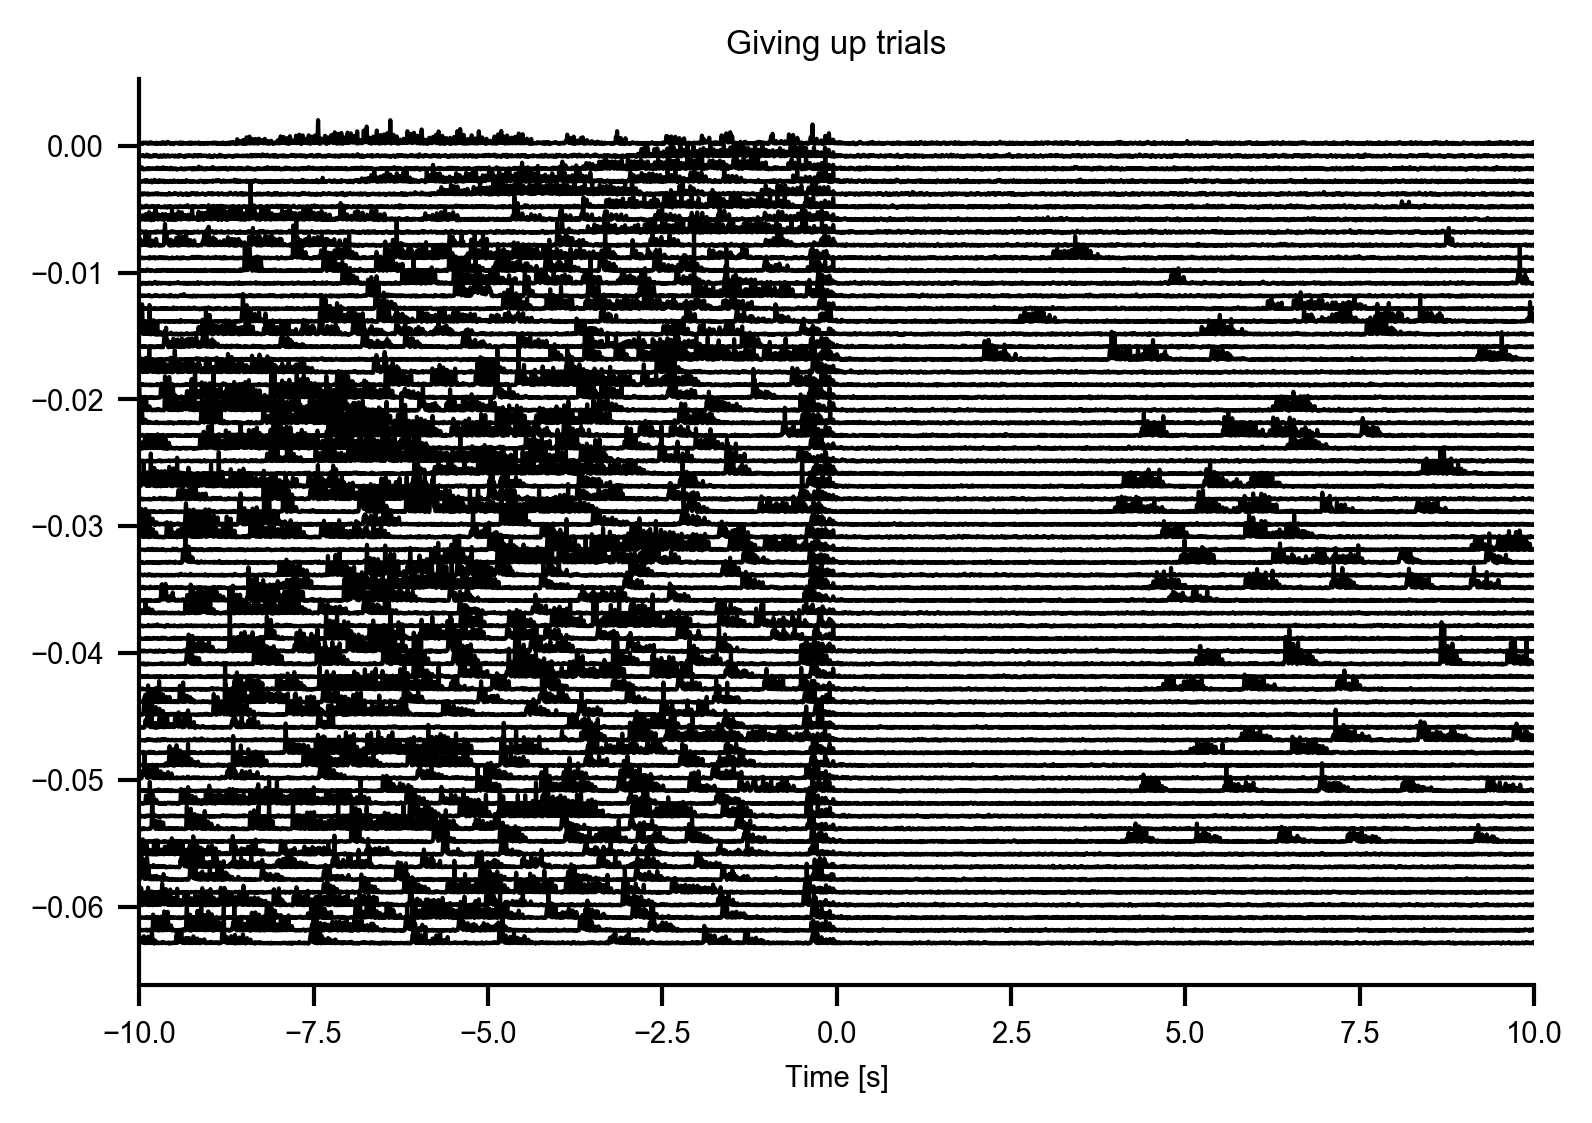

In [15]:
t_points = [10, 20, 30]
fig, axs = plt.subplots(nrows=1, sharex=True, dpi=300)
window = np.arange(-10 * 6000, 10 * 6000)
x_axis_ep = window / 6000

trig_ep_gu = triggered_behavior(gu_inds, window, swims)
scale = .001

stackline(x_axis_ep, trig_ep_gu, axis=axs, scale=scale, color='k', linewidth=1)
axs.title.set_text('Giving up trials')
axs.set_xlabel('Time [s]')

In [16]:
trial_behavior_path = f'/groups/ahrens/ahrenslab/davis/data/ngm/{exp_name}_trial_behavior.h5'
with File(trial_behavior_path) as f:
    f['gu_trials'] = triggered_behavior(gu_inds, window, swims)
    f['ngu_trials'] = triggered_behavior(ngu_inds, window, swims)
    f['window'] = window
    f['swims'] = swims

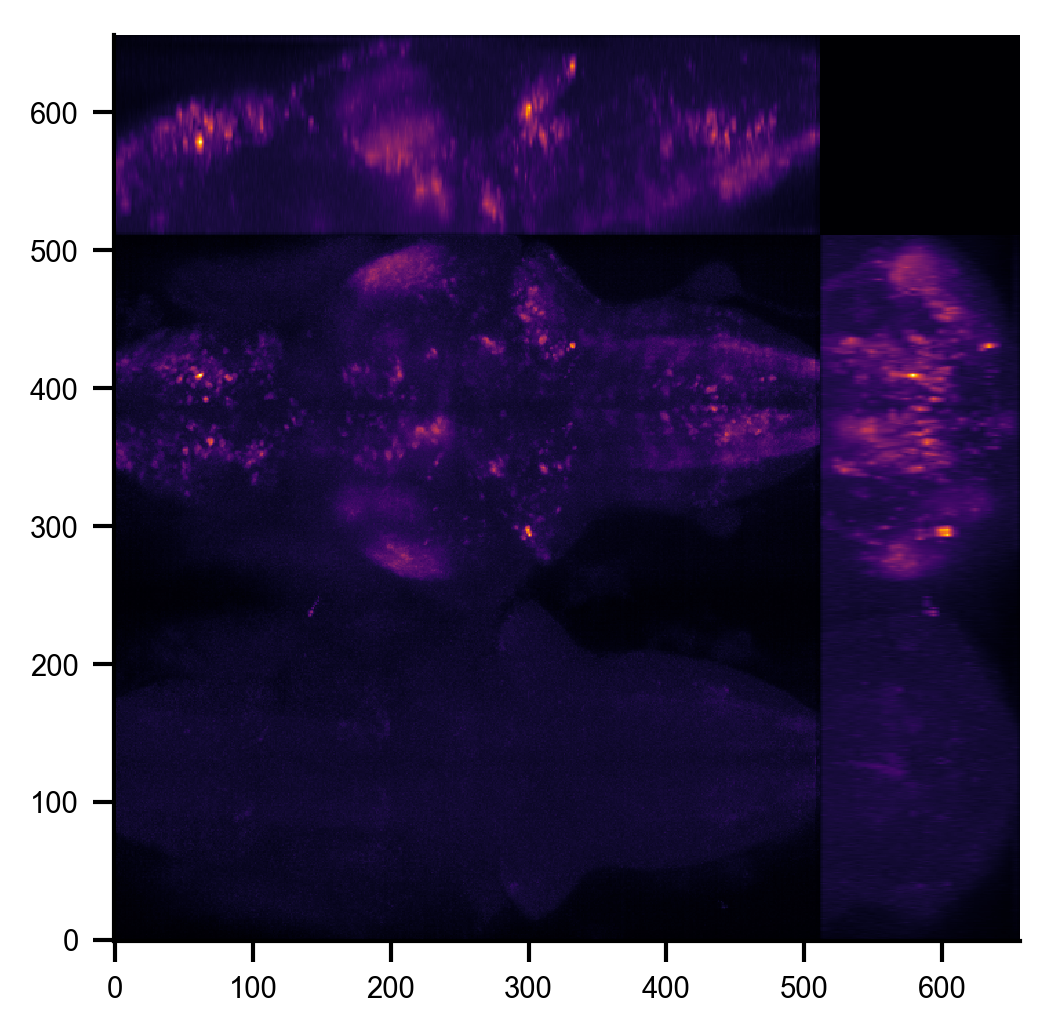

In [11]:
fig, axs = plt.subplots(dpi=300)
t = 8
plt.imshow(proj_fuse(trig_ngu[t], np.max, aspect=aspect), origin='lower', cmap='inferno')

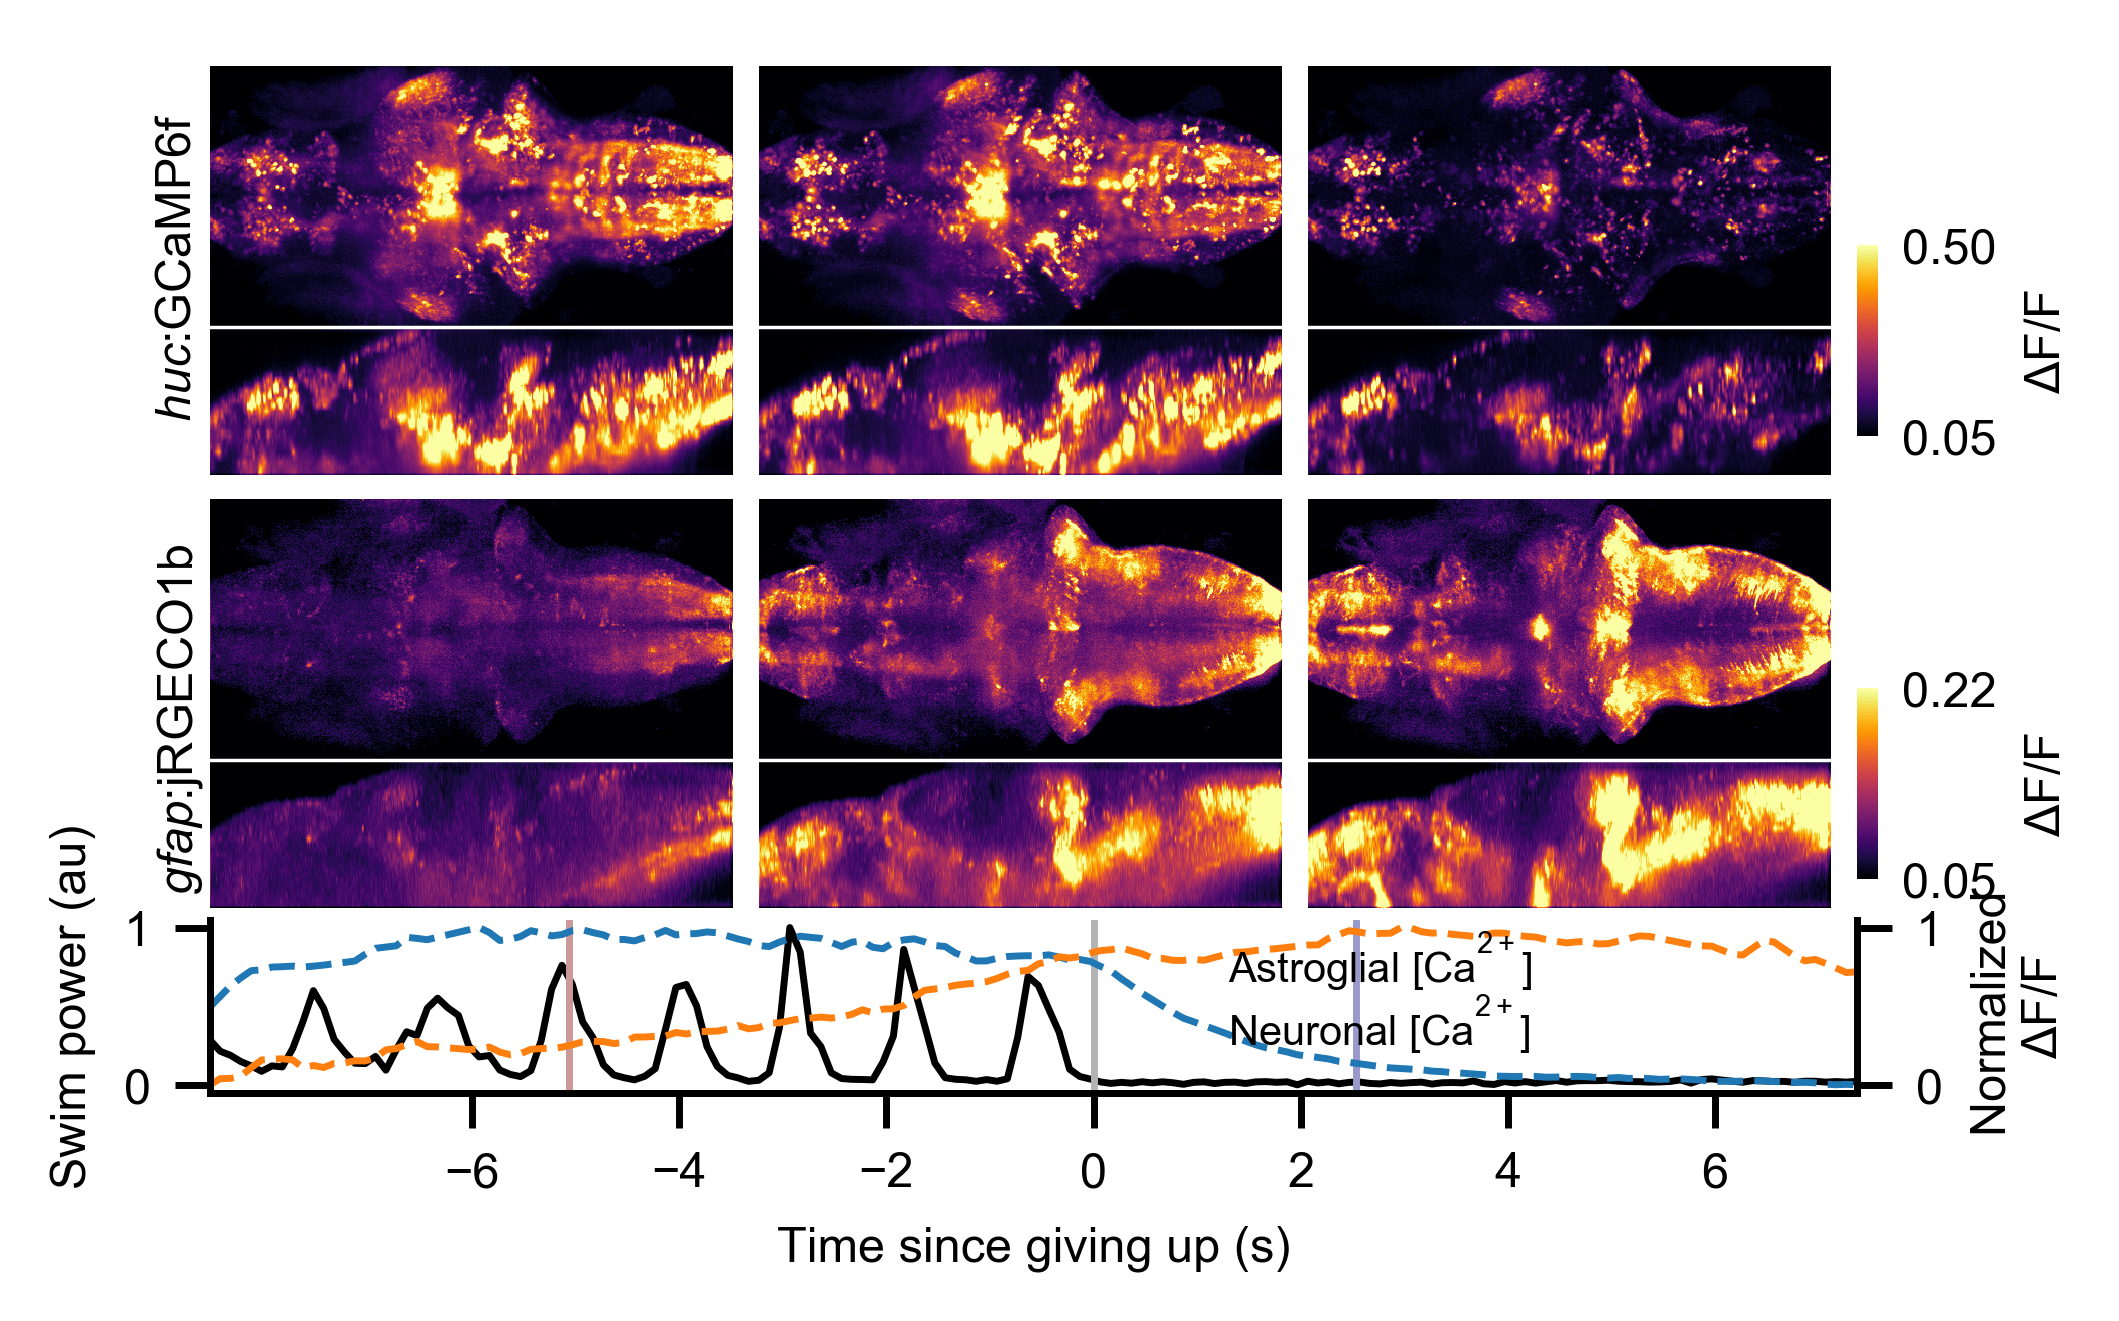

In [12]:
fontsize = 7
to_show = [-8, 0, 4]

# clims for the single-trial example
genotypes = ['n', 'g']
genotype_labels = dict(g=r'$gfap$:jRGECO1b', n=r'$huc$:GCaMP6f')

dff_label = r'$\mathregular {\Delta F/F}$'

timemode=''
if hasattr(to_show[0], '__iter__'):
    timemode='ranges'    
    t_points = []
    for r_ in to_show:
        t_points.append(np.array([np.where(window_im == t)[0][0] for t in r_]))
else:
    timemode='points'
    t_points = [np.where(window_im == t)[0][0] for t in to_show]

vol = trig_gu
#triggers = gu_inds

dims= vol.shape

cmap='inferno'
x_axis_im = window_im / fs_im
window_ep = np.arange(x_axis_im[0] * 6000, x_axis_im[-1] * 6000).astype('int')
ds_ep = 150
x_axis_ep = window_ep[::ds_ep] / 6000

# load mika's matrix of interpolated brain averages
mika_interp = loadmat('/groups/ahrens/ahrenslab/davis/data/ngm/trigger_averages_intp_v3.mat')
x_axis_ep = np.squeeze(mika_interp['time'])
start, stop = -8,8, 
tr = slice(np.where(x_axis_ep > start)[0][0], np.where(x_axis_ep > stop)[0][0])

x_axis_ep = x_axis_ep[tr] - 1/fs_im
trig_ep_gu = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,0], 1), out_range=(0,1))
mean_n_tr = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,1], 1), out_range=(0,1))
mean_g_tr = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,2], 1), out_range=(0,1))

#mean_n_tr = rescale_intensity(vol[:, :, rois['n'][0], rois['n'][1]].mean((1,2,3)), out_range=(0,1))
#mean_g_tr = rescale_intensity(vol[:, :, rois['g'][0], rois['g'][1]].mean((1,2,3)), out_range=(0,1))

#trig_ep_gu = median_filter(np.percentile(triggered_behavior(triggers, window_ep, swims), 100, axis=0), size=1000)
#trig_ep_gu = rescale_intensity(trig_ep_gu, out_range=(0,1))[::ds_ep]
#trig_ep_gu = rescale_intensity(decimate(zscore(trig_ep_gu), ds_ep, ftype='fir', n=300), out_range=(0,1))

scale = 1

fig_ims = plt.figure(figsize=(scale * (8.5 / 2), scale * (11 / 4)), dpi=500)
gs = gridspec.GridSpec(3, len(t_points), height_ratios=[2.5, 2.5, 1], hspace=None, wspace=0)
axs_ims = []
axs_ims.append([plt.subplot(gs[0,t]) for t in range(len(t_points))])
axs_ims.append([plt.subplot(gs[1,t]) for t in range(len(t_points))])

axs_ts_ep = plt.subplot(gs[-1,:])

colors = [(.8,.6,.6), (.7,.7,.7), (.6,.6,.8), (.3, .3, .3)]

clims = dict(g=[.05, .22], n=[.05, .5])

# plot images
for ind, t in enumerate(t_points):        
    for ind_g, val in enumerate(genotypes):
        cur_axs = axs_ims[ind_g][ind]
        cur_axs.axis('off')
        
        if timemode == 'points':
            to_show = my_proj(vol[t][rois[val][::-1]], np.max, aspect=aspect)
        elif timemode == 'ranges':
            to_show = my_proj(vol[t].max(0)[rois[val][::-1]], np.max, aspect=aspect)
        
        axs_ims[ind_g][ind].imshow(to_show, cmap=cmap, clim=clims[val], origin='lower')
        # draw a white line at the boundary between the projections
        axs_ims[ind_g][ind].plot([0, to_show.shape[-1]], 2*[vol.shape[1] * aspect[0]], color='w', linewidth=.5)

        if ind == 0:
            cur_axs.text(-.1 * np.diff(cur_axs.get_xlim())[::-1], .8 * np.diff(cur_axs.get_ylim())[::-1], genotype_labels[val], color='k', fontsize=fontsize, rotation=90)
           # cur_axs.set_ylabel(genotypes[val])
    
# plot corresponding timeseries
axs_ts_ep.plot(x_axis_ep, trig_ep_gu, color='k', linewidth=1)

# plot mean of glia and neurons
axs_ts_im = axs_ts_ep.twinx()
axs_ts_im.plot(x_axis_ep, mean_n_tr, linewidth=1, linestyle='--');
axs_ts_im.plot(x_axis_ep, mean_g_tr, linewidth=1, linestyle='--');
axs_ts_im.text(1.3, .25, r'Neuronal [$\mathregular {Ca^{2+}}$]', fontsize=6)
axs_ts_im.text(1.3, .65, r'Astroglial [$\mathregular {Ca^{2+}}$]', fontsize=6)
axs_ts_im.yaxis.set_label_position("right")
axs_ts_im.set_ylabel('Normalized \n{0}'.format(dff_label))
axs_ts_im.spines['right'].set_visible(True)
axs_ts_im.set_yticks([0,1])
axs_ts_ep.set_yticks([0,1])
axs_ts_ep.set_xticks(range(-6, 8, 2))

axs_ts_ep.set_ylabel('Swim power (au)', fontsize=fontsize)
axs_ts_ep.set_xlabel('Time since giving up (s)', fontsize=fontsize)

axs_ts_im.set_xlim(x_axis_ep[0], x_axis_ep[-1])
axs_ts_ep.set_xlim(x_axis_ep[[0,-1]])

if timemode == 'points':
    [axs_ts_im.axvline(window_im[t] / fs_im, zorder=0, linewidth=1, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]
elif timemode =='ranges':
    [axs_ts_im.axvspan(*window_im[t[[0,-1]]] / fs_im, zorder=0, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]

for ind_g, val in enumerate(genotypes):
    b = offset_colorbar(fig_ims, axs_ims[ind_g][-1], ticks=clims[val])    
    b.ax.set_ylabel(dff_label, fontsize=fontsize, fontname='Arial')
    b.ax.tick_params(width=0)
    b.ax.tick_params(length=0)
plt.subplots_adjust(hspace=0, wspace=0)


plt.savefig(dirs['output'] + '{0}_triggered_average_gu.pdf'.format(exp_name))
with File(dirs['output'] + '{0}_triggered_average_metadata.h5'.format(exp_name),'w') as f:
    f['glia_mean'] = mean_g
    f['neuron_mean'] = mean_n
    f['experiment_name'] = exp_name
    f['average_window_frames'] = window_im
    f['trigger_frames'] = frames_gu
    f['fs_im_Hz'] = fs_im 

In [ ]:
from functools import partial
tmp = trig_ep_gu = triggered_behavior(triggers, window_ep, swims)
fig, axs = plt.subplots(figsize=(6,12), dpi=300, nrows=3)
fs_ep = 6000
kw = 6000 
kern = np.ones(kw)
kern /= kern.sum()
smoother = partial(np.convolve, kern, mode='same')
smoothed = np.apply_along_axis(smoother,1, tmp)
x_axis = window_ep / fs_ep
x_axis_smoothed = x_axis
axs[0].plot(x_axis, 1000 * tmp.T + np.arange(tmp.shape[0]));

axs[1].plot(x_axis_smoothed, 10000 * smoothed.T + np.arange(tmp.shape[0]));
inds = np.arange(-6 * fs_ep, 6 * fs_ep, kw) + np.where(window_ep > 0)[0][0] + kw//2
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds], color='k')
num_trials = tmp.shape[0]
#[axs[2].scatter((x_axis_smoothed[i],) * num_trials, smoothed[:,i]) for i in inds]
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds] + smoothed.std(0)[inds], color='gray', label='+/-STD')
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds] - smoothed.std(0)[inds], color='gray')
axs[2].legend()
[ax.set_xlabel('Time since giving up (s)') for ax in axs]
axs[0].set_ylabel('Raw trials');
axs[1].set_ylabel('Smoothed with {0} s boxcar'.format(kw/fs_ep));
axs[2].set_ylabel('Trial average of smoothed data, sampled at {0} s intervals'.format(kw/fs_ep));